In [ ]:
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size, image_size = 1, 28
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)                             
dataloader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class AutoEncodederLinear(nn.Module):
    def __init__(self):
        super(AutoEncodederLinear, self).__init__()        
        self.autoEnco = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )
    def forward(self, input):
        recon = self.autoEnco(input)
        return recon

In [ ]:
class AutoEncodederLinear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def rebatch(dataloader):
    imgs, lables = [], []
    for img, lable in dataloader:
        imgs.append(img.reshape(1, 28, 28))
        lables.append(lable)
    return imgs, lables

In [ ]:
def rebatch(dataloader):
    imgs, lables = [], []
    for img, lable in dataloader:
        imgs.append(img.reshape(-1, image_size**2))
        lables.append(lable)
    return imgs, lables

def get_few_shot_dict(lables, imgs):
    few_shot_dict_img = dict()
    few_shot_dict_index = dict()
    for i in range(len(lables)):
        label = lables[i].item()
        if label not in few_shot_dict_img:
            few_shot_dict_img[label] = []
            few_shot_dict_index[label] = []
        few_shot_dict_img[label].append(imgs[i].clone())
        few_shot_dict_index[label].append(i)
    return few_shot_dict_img, few_shot_dict_index

def init_model_optim(device):
    model = AutoEncodederLinear().to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-5)
    return model, optimizer

def train(device, few_shot_dict, imgs, num_shots):
    criterion = nn.MSELoss()
    for key in few_shot_dict:
        los = 1
        model, optimizer = init_model_optim(device)
        while los > 0.01:
            data = torch.stack(few_shot_dict[key][:num_shots]).to(device)
            recon = model(data)
            loss = criterion(recon, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            los = loss.item()
        torch.save(model.state_dict(), str(key) + '.pth')

def get_test_data(num_shots, imgs):
    test_img, test_lables = imgs.copy(), lables.copy()
    for key in few_shot_dict:
        for img in few_shot_dict_index[key][:num_shots]:
            del test_img[img]
            del test_lables[img]
    return test_img, test_lables

def mse_row_wise(eval, true):
    return np.square(np.subtract(eval, true)).mean(1)

def eval_loss(lables, imgs, total):
    model = AutoEncodederLinear().to(device)
    acur = 0
    los = np.zeros((10, total))
    for i in range(10):
        model.load_state_dict(torch.load(str(i)+'.pth'))
        ori = torch.stack(imgs[:total]).clone().to(device)
        recon = model(ori)
        ori = ori.reshape(total, 784).cpu().detach().numpy()
        recon = recon.reshape(total, 784).cpu().detach().numpy()
        MSE_loss = mse_row_wise(ori, recon)
        los[i] = MSE_loss
    los = los.T
    for num in range(total):
        label = lables[num].item()
        if np.argmin(los[num]) == label:
            acur += 1/total    
    return acur

In [ ]:
imgs, lables = rebatch(dataloader)
few_shot_dict, few_shot_dict_index = get_few_shot_dict(lables, imgs)

In [ ]:
train(device, few_shot_dict, imgs, 200)

In [ ]:
testimgs, testlables = get_test_data(200, imgs)
eval_loss(testlables, testimgs, len(testimgs))

0.932241379310969

In [ ]:
few_shots = [i for i in range(1, 101, 5)]
accuracys = []

for shot in few_shots:
    print("Train: ", shot)
    train(device, few_shot_dict, imgs, shot)
    testimgs, testlables = get_test_data(shot, imgs)
    acur = eval_loss(testlables, testimgs, len(testimgs))
    print("Accuracy: ", acur)
    accuracys.append(acur)

Train:  1
Accuracy:  0.5143690615101331
Train:  11
Accuracy:  0.7264818834532287
Train:  21
Accuracy:  0.8073925405580821
Train:  31
Accuracy:  0.8409113754405854
Train:  41
Accuracy:  0.8513676791399623
Train:  51
Accuracy:  0.8632879475536394
Train:  61
Accuracy:  0.8716450580917183
Train:  71
Accuracy:  0.8827964243541576
Train:  81
Accuracy:  0.8880385200201923
Train:  91
Accuracy:  0.8928752750035637
Train:  101
Accuracy:  0.8958467536879418
Train:  111
Accuracy:  0.8949906605527933
Train:  121
Accuracy:  0.8944378295619998
Train:  131
Accuracy:  0.8936786505360134
Train:  141
Accuracy:  0.8940092165893302
Train:  151
Accuracy:  0.8969567447424595
Train:  161
Accuracy:  0.8994177085116629
Train:  171
Accuracy:  0.8993995539533269
Train:  181
Accuracy:  0.9009108094181388
Train:  191
Accuracy:  0.9010156653467244


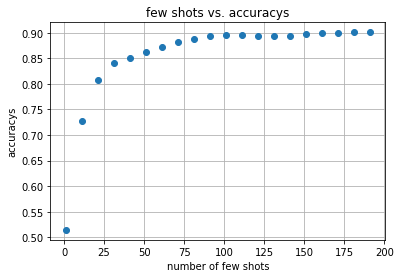

In [ ]:
plt.plot(few_shots, accuracys, 'o')
plt.xlabel('number of few shots')
plt.ylabel('accuracys')
plt.title('few shots vs. accuracys')
plt.grid(True)
plt.show()

In [ ]:
few_shots_big = [i for i in range(100, 1100, 100)]
accuracys_big = []

for shot in few_shots_big:
    print("Train: ", shot)
    train(device, few_shot_dict, imgs, shot)
    testimgs, testlables = get_test_data(shot, imgs)
    acur = eval_loss(testlables, testimgs, len(testimgs))
    print("Accuracy: ", acur)
    accuracys_big.append(acur)

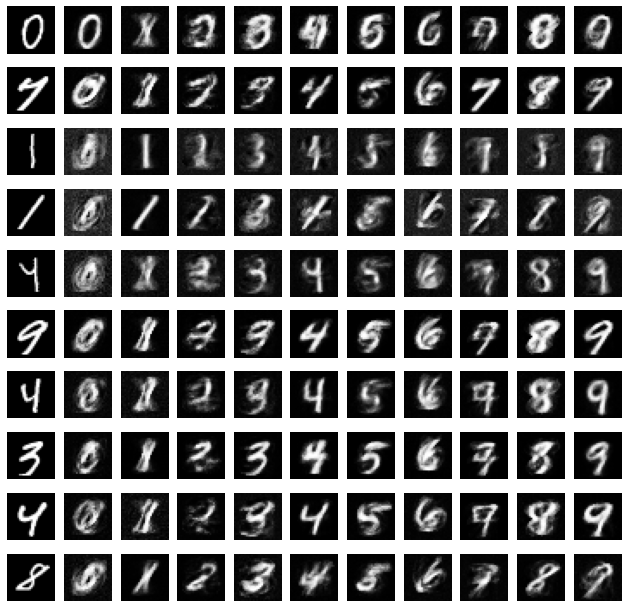

In [ ]:
model = AutoEncodederLinear().to(device)
numbers = 10
plt.figure(figsize=(11,11))
plt.gray()
for j in range(numbers):
  for i in range(10):
    model.load_state_dict(torch.load(str(i) + '.pth'))
    test = imgs[1000+j].clone().to(device)
    recon = model(test).cpu().detach().numpy()
    plt.subplot(numbers, 11, j*11+i+2)
    plt.axis('off')
    plt.imshow(recon.reshape(28, 28))
  plt.subplot(numbers, 11, 1+j*11)
  plt.axis('off')
  plt.imshow(test.cpu().detach().numpy().reshape(28, 28))